In [1]:
import sys, os, re
sys.path.append(os.path.abspath('../'))

from glob import glob
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from typing import List, Tuple

from tensorflow.python.keras.preprocessing.image_dataset import load_image
from tqdm import tqdm
import umap

from matplotlib import pyplot as plt
from IPython.display import display, HTML
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import utils

from utils import MetaData, MetaDataItem, CLASS_NAMES

In [2]:
experiment_dir = "../experiments/tool-iter-01/"
data_dir = os.path.join(experiment_dir, 'data', 'train', 'ii')

In [3]:
model_path = os.path.join(experiment_dir, "checkpoints", "imagenet-finetuned")
model = utils.get_feature_extractor(model_path)

Using weights: None
Loading weights: ../experiments/tool-iter-01/checkpoints/imagenet-finetuned


In [4]:
image_paths = list(Path(data_dir).glob("*.png"))

In [5]:
feature_map = utils.get_feature_map(model, image_paths)
feature_map.shape

100%|██████████| 167/167 [00:01<00:00, 100.96it/s]


(167, 256)

In [6]:
pca = PCA(n_components=0.95)
feature_map_pca = pca.fit_transform(feature_map)

In [7]:
feature_map_pca.shape

(167, 23)

In [8]:
n_clusters = 50
km = KMeans(n_clusters=n_clusters, random_state=42, verbose=0, algorithm="full", n_init=20 )
kmeans_labels = km.fit_predict(feature_map)

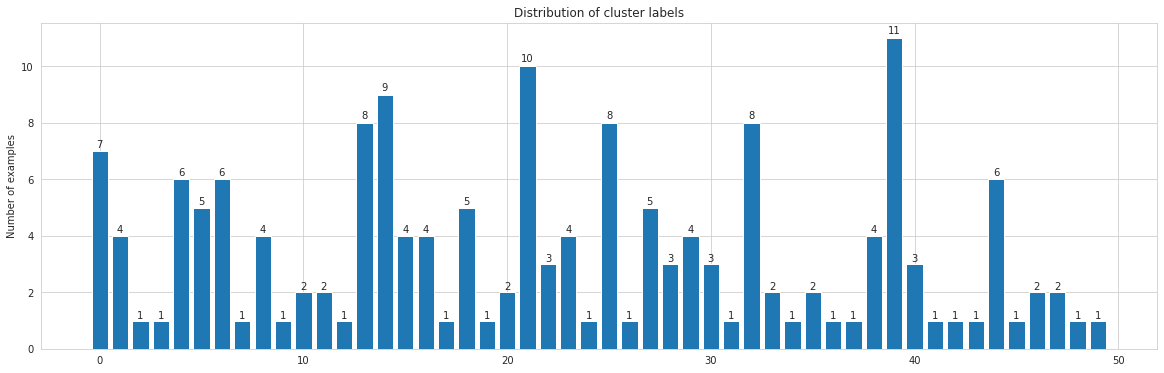

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
label_counts = np.bincount(kmeans_labels)
rects = ax.bar(range(len(label_counts)), label_counts)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, '%d' % int(height), ha='center', va='bottom')
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of cluster labels");

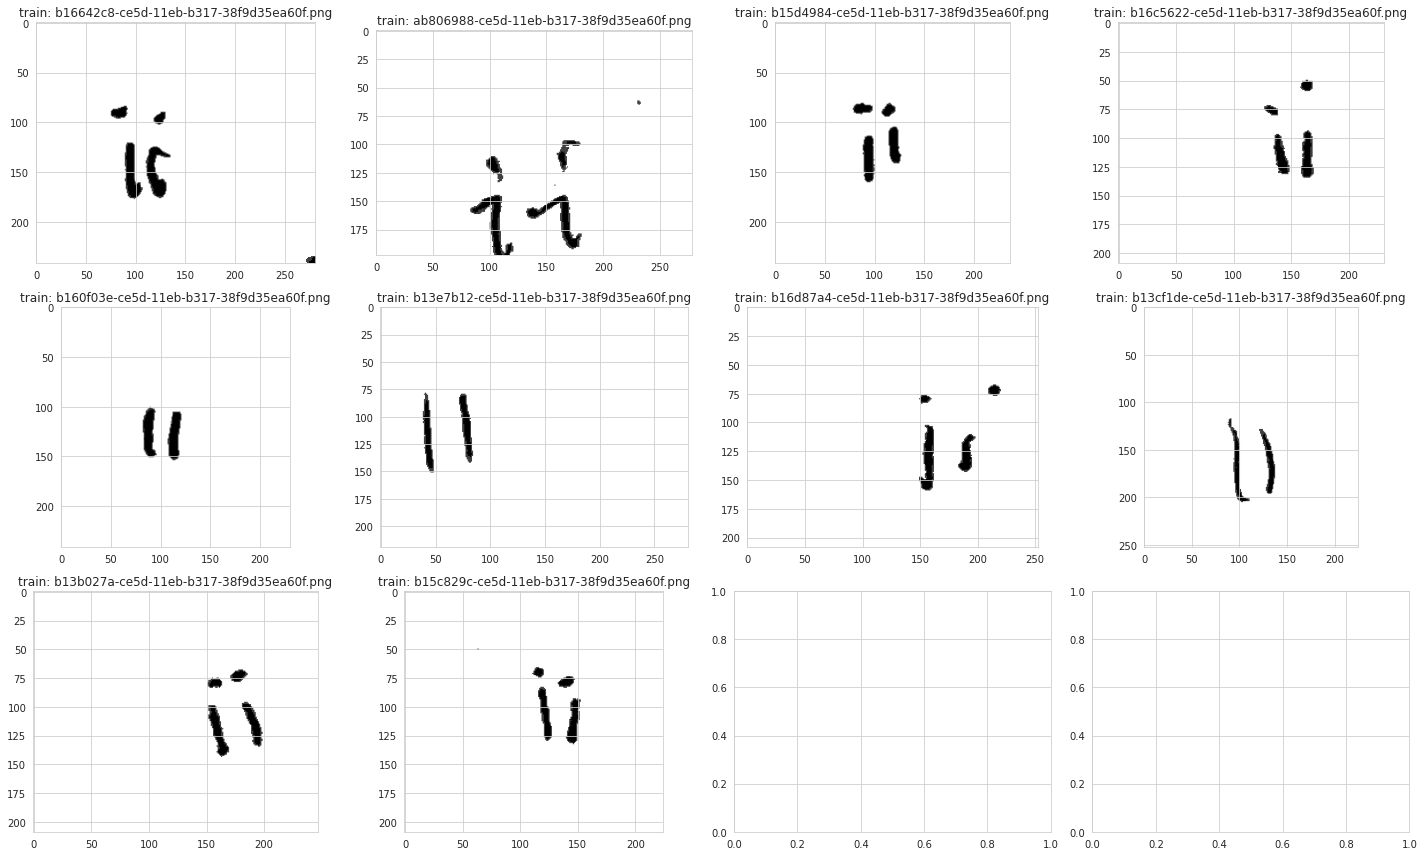

In [10]:
image_paths_in_cluster = np.array(image_paths)[kmeans_labels == 21]

ncols = 4
nrows = int(np.ceil(len(image_paths_in_cluster) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_path in zip(axes.ravel(), image_paths_in_cluster):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"{image_path.parent.parent.name}: {image_path.name}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()